In [1]:
import numpy as np
import cvxpy as cp

import scipy

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
import torch
import torch.nn.functional as F
import scipy.linalg

def precision_recovery(true_support, estimated_support):
    true_positives = len(set(true_support).intersection(set(estimated_support)))
    if len(estimated_support) == 0:
        return 0.0  # Avoid division by zero
    return true_positives / len(estimated_support)

def ISTA_torch(y, A, S, rho=0.5, L=1, max_itr=300):
    loss = torch.zeros(max_itr)  # Store NMSE in dB
    powers = torch.zeros(max_itr)  # Store power values
    precisions = torch.zeros(max_itr)  # Store precision values

    x_hat = torch.zeros(A.shape[1])
    proj = torch.nn.Softshrink(lambd=rho / L)

    # Determine true support
    true_support = torch.nonzero(S, as_tuple=True)[0].tolist()

    for idx in range(max_itr):
        # Gradient update step
        x_tilde = x_hat - 1 / L * (A.T @ (A @ x_hat - y))
        x_hat = proj(x_tilde)

        # NMSE computation
        mse_loss = F.mse_loss(x_hat, S, reduction="sum").data.item()
        signal_power = torch.sum(S**2).item()

        loss[idx] = mse_loss
        powers[idx] = signal_power

        # Calculate estimated support
        estimated_support = torch.nonzero(x_hat > 1e-6, as_tuple=True)[0].tolist()

        # Compute precision
        precisions[idx] = precision_recovery(true_support, estimated_support)

    return loss, powers, precisions

def ISTA_BATCH(test_loader, T, A, rho=0.5):
    A = A.cpu()
    m = A.shape[1]
    # Find the largest eigenvalue of A^T A (used as L)
    L = float(scipy.linalg.eigvalsh(A.t() @ A, eigvals=(m - 1, m - 1)))

    # Aggregate T iterations' NMSE loss and precision
    losses_ = torch.zeros(T)
    powers_ = torch.zeros(T)
    precisions_ = torch.zeros(T)

    for _, (y, S) in enumerate(test_loader.dataset):
        losses, powers, precisions = ISTA_torch(y=y, A=A, S=S, L=L, max_itr=T)
        losses_ += losses
        powers_ += powers
        precisions_ += precisions

    # Return the mean NMSE in dB and mean precision for all batches
    mean_losses = 10 * torch.log10(losses_ / powers_)
    mean_precisions = precisions_ / len(test_loader.dataset)  # Average over batches

    return (mean_losses, mean_precisions)

In [3]:
class SyntheticSignals():
    def __init__(self, A, n, m, p = 0.1, s_sigma = 1, SNR = None, size = 1000, batch_size = 512):
        
        # Model complexity
        self.n = n                          # Number of samples in the original signal
        self.m = m                          # Number of samples through the linear transformation

        # Sensing matrix
        if A is None:                           
            self.A = self.A_initialization()          
        else:
            self.A = A

        # Sparsity and noise
        self.p = p                          # Sparsity of the signal in terms of percentage of components being non zero

        self.s_sigma = s_sigma              # Scale of the original sparse signals             
        self.SNR = SNR                      # Signal-to-noise ratio 

        # Size and batchsize
        self.batch_size = batch_size
        self.size = size                    # Size of the dataset

        # Preallocation
        self.x = torch.zeros(self.size,self.n)
        self.y = torch.zeros(self.size,self.m)
        
        # Generating the dataset
        self.set_data()

    def A_initialization(self):

        A = torch.normal(0, torch.sqrt(torch.tensor(1/self.m)), size = (self.m, self.n))
        A /= torch.linalg.norm(A, dim = 0)
        return A
    
    def set_tuple(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        idxs = np.random.choice(self.n, int(self.p * self.n), replace=False)
        peaks = np.random.normal(scale=self.s_sigma, size = int(self.p * self.n))

        # Generating the original signal and its corrupted observations
        self.x[i, idxs] = torch.from_numpy(peaks).to(self.x)
        self.y[i,:] = self.A @ self.x[i,:] 
        
        if self.SNR is not None:
            var = torch.mean(self.y[i,:]**2) / self.SNR
            self.y[i,:] += torch.normal(mean = 0, std=torch.sqrt(torch.tensor(var)), size=(self.m,))

    def set_data(self):
        for i in range(self.size):
            self.set_tuple(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.y, self.x),
                               batch_size = self.batch_size,
                               shuffle = True)

In [4]:
def ddxEXP(x, theta):
    return torch.sign(x) * theta * (1 - torch.exp(-theta * torch.abs(x)))

def ddxNEG(x, theta, p):
    return -torch.sign(x) * p * theta * (1 - (1 + theta * torch.abs(x))**(p - 1))

def ddxSCAD(x, a, theta):
    abs_x = torch.abs(x)
    
    mask1 = (abs_x <= 1)
    mask2 = (1 / theta < abs_x) & (abs_x <= a / theta)
    mask3 = (abs_x > a / theta)
    
    # Compute the value for each condition
    val1 = torch.zeros_like(x)
    val2 = torch.sign(x) * (2 * theta * (theta * abs_x - 1)) / (a**2 - 1)
    val3 = torch.sign(x) * (2 * theta / (a + 1))
    
    # Apply the masks to compute the final result
    result = torch.where(mask1, val1, torch.where(mask2, val2, val3))
    
    return result

#____________________________________

def etaEXP(theta):
    return theta

def etaNEG(theta, p = - 1):
    return - p * theta

def etaSCAD(theta, a = 2):
    return 2 * theta / (a + 1)

In [5]:
import torch
import torch.nn.functional as F
import scipy.linalg

def precision_recovery(true_support, estimated_support):
    true_positives = len(set(true_support).intersection(set(estimated_support)))
    if len(estimated_support) == 0:
        return 0.0  # Avoid division by zero
    return true_positives / len(estimated_support)

def DCISTA_torch(y, A, S, mode, rho=0.5, L=1, p=-0.1, a=0.1, theta=2, max_itr=300):
    loss = torch.zeros(max_itr)  # Store NMSE in dB
    powers = torch.zeros(max_itr)  # Store power values
    precisions = torch.zeros(max_itr)  # Store precision values

    x_hat = torch.zeros(A.shape[1])

    # Determine true support
    true_support = torch.nonzero(S, as_tuple=True)[0].tolist()

    if mode == 'EXP':
        theta = 1
        proj = torch.nn.Softshrink(lambd=rho * etaEXP(theta) / L)
    if mode == 'PNEG':
        theta = 2
        proj = torch.nn.Softshrink(lambd=rho * etaNEG(theta, p) / L)
    if mode == 'SCAD':
        theta = 1
        a = 2
        proj = torch.nn.Softshrink(lambd=rho * etaSCAD(theta, a) / L)

    for idx in range(max_itr):
        # Gradient update step
        if mode == 'EXP':
            x_tilde = x_hat - 1 / L * (A.T @ (A @ x_hat - y) + rho * ddxEXP(x_hat, theta))
        if mode == 'PNEG':
            x_tilde = x_hat - 1 / L * (A.T @ (A @ x_hat - y) + rho * ddxNEG(x_hat, theta, p))
        if mode == 'SCAD':
            x_tilde = x_hat - 1 / L * (A.T @ (A @ x_hat - y) + rho * ddxSCAD(x_hat, a, theta))

        x_hat = proj(x_tilde)

        # NMSE computation
        mse_loss = F.mse_loss(x_hat, S, reduction="sum").data.item()
        signal_power = torch.sum(S**2).item()

        loss[idx] = mse_loss
        powers[idx] = signal_power

        # Calculate estimated support
        estimated_support = torch.nonzero(x_hat > 1e-6, as_tuple=True)[0].tolist()

        # Compute precision
        precisions[idx] = precision_recovery(true_support, estimated_support)

    return loss, powers, precisions

def DCISTA_BATCH(test_loader, T, A, mode, rho=0.5):
    A = A.cpu()
    m = A.shape[1]
    # Find the largest eigenvalue of A^T A (used as L)
    L = float(scipy.linalg.eigvalsh(A.t() @ A, eigvals=(m - 1, m - 1)))

    # Aggregate T iterations' NMSE loss and precision
    losses_ = torch.zeros(T)
    powers_ = torch.zeros(T)
    precisions_ = torch.zeros(T)

    for _, (y, S) in enumerate(test_loader.dataset):
        losses, powers, precisions = DCISTA_torch(y=y, A=A, S=S, L=L, mode=mode, max_itr=T)
        losses_ += losses
        powers_ += powers
        precisions_ += precisions

    # Return the mean NMSE in dB and mean precision for all batches
    mean_losses = 10 * torch.log10(losses_ / powers_)
    mean_precisions = precisions_ / len(test_loader.dataset)  # Average over batches

    return (mean_losses, mean_precisions)

In [22]:
M = 10
LAYERS = 100
BETA_INIT = 0.4
SNR = None

ISTA_LOSS = torch.zeros((M, LAYERS))
DCISTA_LOSS_EXP = torch.zeros((M, LAYERS))
DCISTA_LOSS_PNEG = torch.zeros((M, LAYERS))
DCISTA_LOSS_SCAD = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)[0]
    DCISTA_LOSS_EXP[m,:] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'EXP', rho = BETA_INIT)[0]
    DCISTA_LOSS_PNEG[m,:] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'PNEG', rho = BETA_INIT)[0]
    DCISTA_LOSS_SCAD[m,:] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'SCAD', rho = BETA_INIT)[0]

100%|██████████| 10/10 [12:04<00:00, 72.49s/it]


In [10]:
ISTA_LOSS = ISTA_LOSS.numpy()
DCISTA_LOSS_EXP = DCISTA_LOSS_EXP.numpy()
DCISTA_LOSS_PNEG = DCISTA_LOSS_PNEG.numpy()
DCISTA_LOSS_SCAD = DCISTA_LOSS_SCAD.numpy()

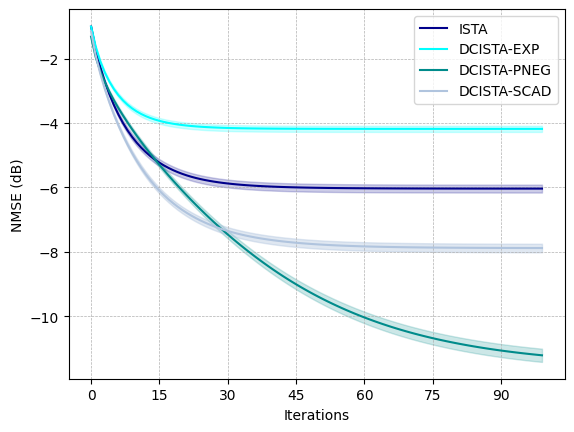

In [24]:
plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='darkblue', 
                alpha=0.2)

plt.plot(np.mean(DCISTA_LOSS_EXP, axis = 0), label='DCISTA-EXP', color='aqua')
plt.fill_between(range(LAYERS), 
                np.mean(DCISTA_LOSS_EXP, axis = 0) - (2/np.sqrt(DCISTA_LOSS_EXP.shape[1])) * np.std(DCISTA_LOSS_EXP, axis = 0), 
                np.mean(DCISTA_LOSS_EXP, axis = 0) + (2/np.sqrt(DCISTA_LOSS_EXP.shape[1])) * np.std(DCISTA_LOSS_EXP, axis = 0), 
                color='aqua', 
                alpha=0.2)

plt.plot(np.mean(DCISTA_LOSS_PNEG, axis = 0), label='DCISTA-PNEG', color='darkcyan')
plt.fill_between(range(LAYERS), 
                np.mean(DCISTA_LOSS_PNEG, axis = 0) - (2/np.sqrt(DCISTA_LOSS_PNEG.shape[1])) * np.std(DCISTA_LOSS_PNEG, axis = 0), 
                np.mean(DCISTA_LOSS_PNEG, axis = 0) + (2/np.sqrt(DCISTA_LOSS_PNEG.shape[1])) * np.std(DCISTA_LOSS_PNEG, axis = 0), 
                color='darkcyan', 
                alpha=0.2)

plt.plot(np.mean(DCISTA_LOSS_SCAD, axis = 0), label='DCISTA-SCAD', color='lightsteelblue')
plt.fill_between(range(LAYERS), 
                np.mean(DCISTA_LOSS_SCAD, axis = 0) - (2/np.sqrt(DCISTA_LOSS_SCAD.shape[1])) * np.std(DCISTA_LOSS_SCAD, axis = 0), 
                np.mean(DCISTA_LOSS_SCAD, axis = 0) + (2/np.sqrt(DCISTA_LOSS_SCAD.shape[1])) * np.std(DCISTA_LOSS_SCAD, axis = 0), 
                color='lightsteelblue', 
                alpha=0.4)

plt.xticks(range(LAYERS))

plt.ylabel('NMSE (dB)')
plt.xlabel('Iterations')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [9]:
M = 10
LAYERS = 100
BETA_INIT = 0.4
SNRs = [1,10,20,30,40,50,60,70,80]

ISTA_LOSS = torch.zeros((M, len(SNRs)))
DCISTA_LOSS_EXP = torch.zeros((M, len(SNRs)))
DCISTA_LOSS_PNEG = torch.zeros((M, len(SNRs)))
DCISTA_LOSS_SCAD = torch.zeros((M, len(SNRs)))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    for j, SNR in enumerate(SNRs):
        test_set = SyntheticSignals(
            A = A_,
            n = n_,        
            m = m_,
            p = p_,
            SNR = 10**(SNR/10),
            size = 100
            ).set_loader()
        
        ISTA_LOSS[m,j] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)[0][-1]
        DCISTA_LOSS_EXP[m,j] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'EXP', rho = BETA_INIT)[0][-1]
        DCISTA_LOSS_PNEG[m,j] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'PNEG', rho = BETA_INIT)[0][-1]
        DCISTA_LOSS_SCAD[m,j] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'SCAD', rho = BETA_INIT)[0][-1]

100%|██████████| 10/10 [11:30<00:00, 69.03s/it]


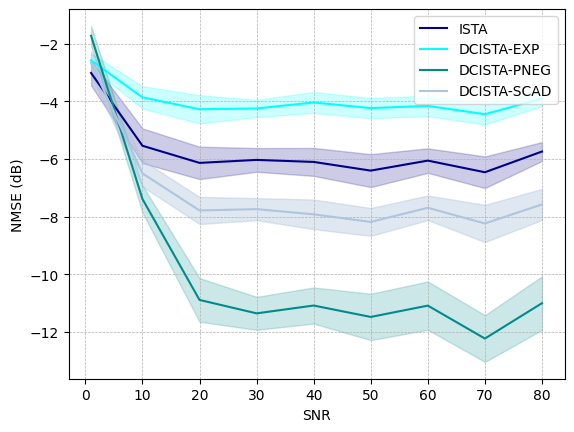

In [15]:
plt.plot(SNRs, np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue')
plt.fill_between(SNRs, 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='darkblue', 
                alpha=0.2)

plt.plot(SNRs, np.mean(DCISTA_LOSS_EXP, axis = 0), label='DCISTA-EXP', color='aqua')
plt.fill_between(SNRs, 
                np.mean(DCISTA_LOSS_EXP, axis = 0) - (2/np.sqrt(DCISTA_LOSS_EXP.shape[1])) * np.std(DCISTA_LOSS_EXP, axis = 0), 
                np.mean(DCISTA_LOSS_EXP, axis = 0) + (2/np.sqrt(DCISTA_LOSS_EXP.shape[1])) * np.std(DCISTA_LOSS_EXP, axis = 0), 
                color='aqua', 
                alpha=0.2)

plt.plot(SNRs, np.mean(DCISTA_LOSS_PNEG, axis = 0), label='DCISTA-PNEG', color='darkcyan')
plt.fill_between(SNRs, 
                np.mean(DCISTA_LOSS_PNEG, axis = 0) - (2/np.sqrt(DCISTA_LOSS_PNEG.shape[1])) * np.std(DCISTA_LOSS_PNEG, axis = 0), 
                np.mean(DCISTA_LOSS_PNEG, axis = 0) + (2/np.sqrt(DCISTA_LOSS_PNEG.shape[1])) * np.std(DCISTA_LOSS_PNEG, axis = 0), 
                color='darkcyan', 
                alpha=0.2)

plt.plot(SNRs, np.mean(DCISTA_LOSS_SCAD, axis = 0), label='DCISTA-SCAD', color='lightsteelblue')
plt.fill_between(SNRs, 
                np.mean(DCISTA_LOSS_SCAD, axis = 0) - (2/np.sqrt(DCISTA_LOSS_SCAD.shape[1])) * np.std(DCISTA_LOSS_SCAD, axis = 0), 
                np.mean(DCISTA_LOSS_SCAD, axis = 0) + (2/np.sqrt(DCISTA_LOSS_SCAD.shape[1])) * np.std(DCISTA_LOSS_SCAD, axis = 0), 
                color='lightsteelblue', 
                alpha=0.4)

plt.xticks(SNRs)

plt.ylabel('NMSE (dB)')
plt.xlabel('SNR')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

In [17]:
np.arange(0.1,0.2,0.01)

array([0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19])

In [6]:
M = 10
LAYERS = 100
BETA_INIT = 0.4
ps = np.arange(0,0.21,0.01)

ISTA_precs = torch.zeros((M, len(ps)))
DCISTA_precs_EXP = torch.zeros((M, len(ps)))
DCISTA_precs_PNEG = torch.zeros((M, len(ps)))
DCISTA_precs_SCAD = torch.zeros((M, len(ps)))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    for j, p in enumerate(ps):
        test_set = SyntheticSignals(
            A = A_,
            n = n_,        
            m = m_,
            p = p,
            SNR = None,
            size = 100
            ).set_loader()
        
        ISTA_precs[m,j] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)[1][-1]
        DCISTA_precs_EXP[m,j] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'EXP', rho = BETA_INIT)[1][-1]
        DCISTA_precs_PNEG[m,j] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'PNEG', rho = BETA_INIT)[1][-1]
        DCISTA_precs_SCAD[m,j] = DCISTA_BATCH(test_set, LAYERS, A_, mode = 'SCAD', rho = BETA_INIT)[1][-1]

100%|██████████| 10/10 [33:16<00:00, 199.68s/it]


In [7]:
ISTA_precs = ISTA_precs.numpy()
DCISTA_precs_EXP = DCISTA_precs_EXP.numpy()
DCISTA_precs_PNEG = DCISTA_precs_PNEG.numpy()
DCISTA_precs_SCAD = DCISTA_precs_SCAD.numpy()

In [8]:
ps = [p * 500 for p in ps]

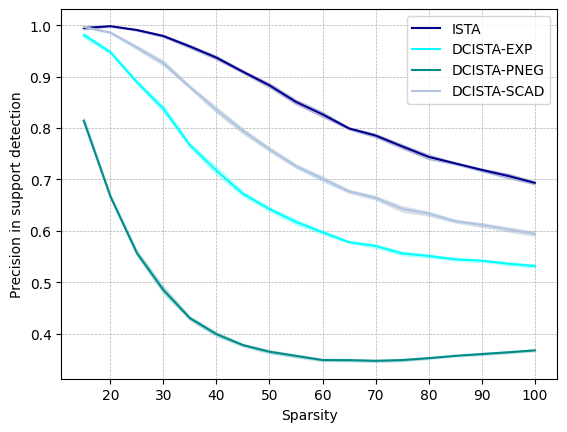

In [18]:
plt.plot(ps[3:], np.mean(ISTA_precs, axis = 0)[3:], label='ISTA', color='darkblue')
plt.fill_between(ps[3:], 
                np.mean(ISTA_precs, axis = 0)[3:] - (2/np.sqrt(ISTA_precs.shape[1])) * np.std(ISTA_precs, axis = 0)[3:], 
                np.mean(ISTA_precs, axis = 0)[3:] + (2/np.sqrt(ISTA_precs.shape[1])) * np.std(ISTA_precs, axis = 0)[3:], 
                color='darkblue', 
                alpha=0.2)

plt.plot(ps[3:], np.mean(DCISTA_precs_EXP, axis = 0)[3:], label='DCISTA-EXP', color='aqua')
plt.fill_between(ps[3:], 
                np.mean(DCISTA_precs_EXP, axis = 0)[3:] - (2/np.sqrt(DCISTA_precs_EXP.shape[1]))* np.std(DCISTA_precs_EXP, axis = 0)[3:], 
                np.mean(DCISTA_precs_EXP, axis = 0)[3:] + (2/np.sqrt(DCISTA_precs_EXP.shape[1])) * np.std(DCISTA_precs_EXP, axis = 0)[3:], 
                color='aqua', 
                alpha=0.2)

plt.plot(ps[3:], np.mean(DCISTA_precs_PNEG, axis = 0)[3:], label='DCISTA-PNEG', color='darkcyan')
plt.fill_between(ps[3:], 
                np.mean(DCISTA_precs_PNEG, axis = 0)[3:] - (2/np.sqrt(DCISTA_precs_PNEG.shape[1])) * np.std(DCISTA_precs_PNEG, axis = 0)[3:], 
                np.mean(DCISTA_precs_PNEG, axis = 0)[3:] + (2/np.sqrt(DCISTA_precs_PNEG.shape[1])) * np.std(DCISTA_precs_PNEG, axis = 0)[3:], 
                color='darkcyan', 
                alpha=0.2)

plt.plot(ps[3:], np.mean(DCISTA_precs_SCAD, axis = 0)[3:], label='DCISTA-SCAD', color='lightsteelblue')
plt.fill_between(ps[3:], 
                np.mean(DCISTA_precs_SCAD, axis = 0)[3:] - (2/np.sqrt(DCISTA_precs_SCAD.shape[1])) * np.std(DCISTA_precs_SCAD, axis = 0)[3:], 
                np.mean(DCISTA_precs_SCAD, axis = 0)[3:] + (2/np.sqrt(DCISTA_precs_SCAD.shape[1])) * np.std(DCISTA_precs_SCAD, axis = 0)[3:], 
                color='lightsteelblue', 
                alpha=0.4)

plt.xticks(ps[3:])

plt.ylabel('Precision in support detection')
plt.xlabel('Sparsity')

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

plt.savefig(r"2_4_4.png", dpi = 600)